In [25]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import xgboost as xgb

from scipy import sparse
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SlopeOne
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV
from datetime import datetime
import os
import random
import gc

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import warnings
warnings.filterwarnings("ignore")


In [24]:
pip install fuzzywuzzy

In [22]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357276 sha256=811a06e2390c369b02a414292f22044da8202baa461ccf156412a90384ef45aa
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [19]:
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = None

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (25,5)

In [31]:
movie_ratings = pd.read_csv("/content/ratings.csv")
movies = pd.read_csv( "/content/movies.csv")


In [32]:
movies["newId"] = range(1, movies["movieId"].nunique()+1)

In [33]:
# Converting the the UTC timestamp to Datetime
movie_ratings["timestamp"] = movie_ratings["timestamp"].apply(lambda x: datetime.utcfromtimestamp(x).strftime("%Y-%m-%d"))

# Merging the movies and ratings data files
movie_ratings = movie_ratings.merge(movies, how="left", on="movieId")

# Renaming the timestamp to date
movie_ratings.rename(columns={"timestamp": "date"}, inplace=True)

# Updating the movieId with the newId
movie_ratings["movieId"] = movie_ratings["newId"]
movies["movieId"] = movies["newId"]

In [35]:

# Checking the features and no. of records in the dataset

print("The number of records are : ", movie_ratings.shape[0])
print("The number of features are : ", movie_ratings.shape[1])
print("The list of features is : ", movie_ratings.columns)
movie_ratings.head()


The number of records are :  86337
The number of features are :  6
The list of features is :  Index(['userId', 'movieId', 'rating', 'date', 'title', 'genres'], dtype='object')


,userId,movieId,rating,date,title,genres
0,610,1069,4.0,1970-01-01,Platoon (1986),Drama|War
1,491,11,4.0,1996-04-11,"American President, The (1995)",Comedy|Drama|Romance
2,491,17,5.0,1996-04-11,Sense and Sensibility (1995),Drama|Romance
3,491,62,4.0,1996-04-11,Mr. Holland's Opus (1995),Drama
4,491,10,4.0,1996-04-11,GoldenEye (1995),Action|Adventure|Thriller


In [36]:
# Checking for duplicates

print("No. of duplicates records in the dataset : ", movie_ratings.columns.duplicated().sum())
# Checking the columns' titles and datatypes

movie_ratings.info()

# Checking the number of missing values in data

movie_ratings.isna().sum()

No. of duplicates records in the dataset :  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86337 entries, 0 to 86336
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   86337 non-null  int64  
 1   movieId  86337 non-null  int64  
 2   rating   86337 non-null  float64
 3   date     86337 non-null  object 
 4   title    86337 non-null  object 
 5   genres   86337 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 4.0+ MB


,0
userId,0
movieId,0
rating,0
date,0
title,0
genres,0


In [37]:

# Checking the feature "userID"

total_users = len(np.unique(movie_ratings["userId"]))
print("The count of unique userID in the dataset is : ", total_users)
print("The top 5 userID in the dataset are : \n", movie_ratings["userId"].value_counts()[:5])

The count of unique userID in the dataset is :  610
The top 5 userID in the dataset are : 
 userId
156    2179
586    1431
572    1326
359    1300
208    1288
Name: count, dtype: int64


In [38]:

# Checking the feature "movieID"

total_movies = len(np.unique(movie_ratings["movieId"]))
print("The count of unique movieID in the dataset is : ", total_movies)
print("The top 5 movieID in the dataset are : \n", movie_ratings["movieId"].value_counts()[:5])

The count of unique movieID in the dataset is :  7920
The top 5 movieID in the dataset are : 
 movieId
294    305
353    295
477    266
316    262
588    257
Name: count, dtype: int64


In [39]:

# Helper function to Change the numeric label in terms of Millions

def changingLabels(number):

    return str(number/10**6) + "M"

In [42]:
# Checking the feature "date"

print("The count of unique date in the dataset is : ", movie_ratings["date"].nunique())
print("The first rating was given on : ", movie_ratings["date"].min())
print("The latest rating was given on : ", movie_ratings["date"].max())
print("The top 5 date in the dataset are : \n", movie_ratings["date"].value_counts()[:5])

The count of unique date in the dataset is :  3262
The first rating was given on :  1970-01-01
The latest rating was given on :  2015-03-30
The top 5 date in the dataset are : 
 date
1999-12-11    1252
2000-08-03    1006
2004-11-10     918
2005-11-23     744
2005-10-07     700
Name: count, dtype: int64


In [43]:
# Checking the feature "title"

movie_list = movie_ratings["title"].unique()
print("The count of unique title in the dataset is : ", movie_ratings["title"].nunique())
print("The top 5 title in the dataset are : \n", movie_ratings["title"].value_counts()[:5])

The count of unique title in the dataset is :  7918
The top 5 title in the dataset are : 
 title
Pulp Fiction (1994)                 305
Forrest Gump (1994)                 295
Jurassic Park (1993)                266
Shawshank Redemption, The (1994)    262
Silence of the Lambs, The (1991)    257
Name: count, dtype: int64


In [44]:
# Extract unique Genres along with their count

unique_genres = {}

def ExtractGenres(x):
    for g in x.split("|"):
        if g not in unique_genres.keys():
            unique_genres[g] = 1
        else:
            unique_genres[g] = unique_genres[g] + 1

movie_ratings["genres"].apply(ExtractGenres)
print("Genres Extracted from the dataset.")

Genres Extracted from the dataset.


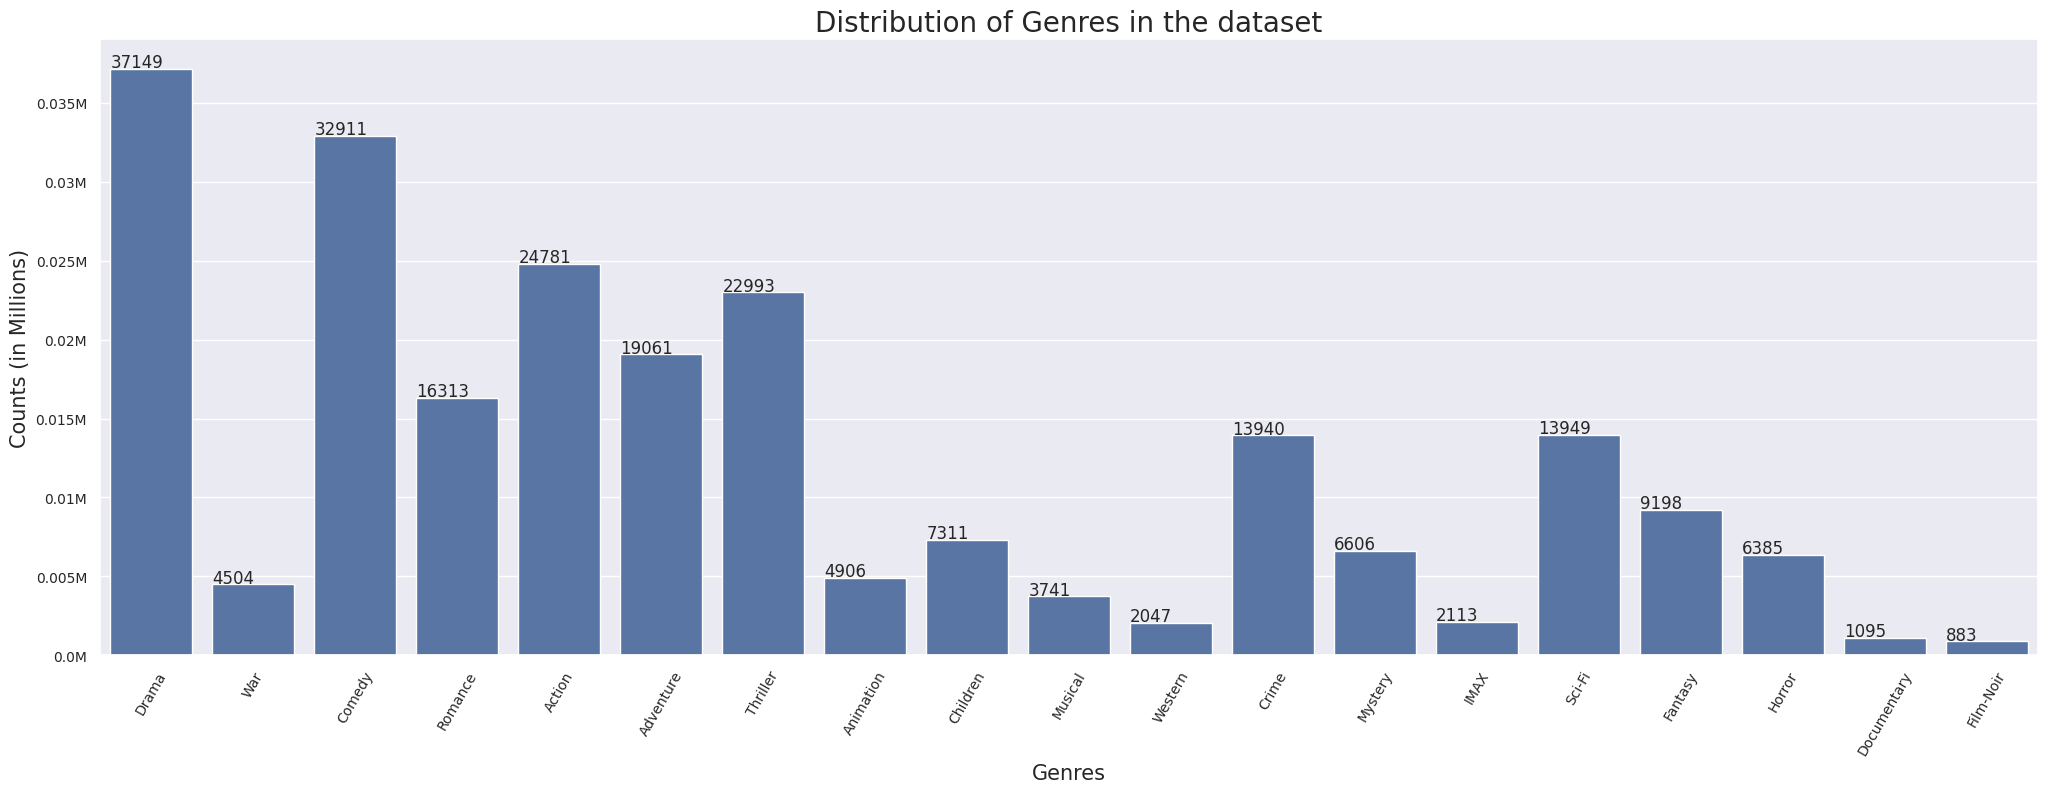

In [45]:
# Visualizing the feature "Genres"

genres_df = pd.DataFrame(list(unique_genres.items()))
genres_df.columns = ["Genre", "Count"]

sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 1, figsize=(25, 8), sharey=True)

sns.barplot(y="Count", x="Genre", data=genres_df, ax=axes)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
for p in axes.patches:
    axes.annotate('{}'.format(int(p.get_height())), (p.get_x(), p.get_height()+100))

plt.tick_params(labelsize = 15)
plt.title("Distribution of Genres in the dataset", fontsize = 20)
plt.xlabel("Genres", fontsize = 15)
plt.xticks(rotation=60, fontsize=10)
plt.yticks(fontsize=10)
plt.ylabel("Counts (in Millions)", fontsize = 15)
plt.show()

In [46]:
movie_ratings.head()

,userId,movieId,rating,date,title,genres
0,610,1069,4.0,1970-01-01,Platoon (1986),Drama|War
1,491,11,4.0,1996-04-11,"American President, The (1995)",Comedy|Drama|Romance
2,491,17,5.0,1996-04-11,Sense and Sensibility (1995),Drama|Romance
3,491,62,4.0,1996-04-11,Mr. Holland's Opus (1995),Drama
4,491,10,4.0,1996-04-11,GoldenEye (1995),Action|Adventure|Thriller


In [47]:
file_path = "/content/drive/MyDrive/Colab Datasets/Movie Recommendation"

if not os.path.isfile(file_path + "/TrainData.pkl"):
    print("Creating Train Data and saving it..")
    movie_ratings.iloc[:int(movie_ratings.shape[0] * 0.80)].to_pickle(file_path + "/TrainData.pkl")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Train Data..")
    Train_Data = pd.read_pickle(file_path + "/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile(file_path + "/TestData.pkl"):
    print("Creating Test Data and saving it..")
    movie_ratings.iloc[int(movie_ratings.shape[0] * 0.80):].to_pickle(file_path + "/TestData.pkl")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    print("Loading Test Data..")
    Test_Data = pd.read_pickle(file_path + "/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Evaluation
print(f'Random Forest RMSE: {mean_squared_error(y_test, rf_predictions, squared=False)}')
print(f'Decision Tree RMSE: {mean_squared_error(y_test, dt_predictions, squared=False)}')


Random Forest RMSE: 51.83369381731876
Decision Tree RMSE: 54.80577346965682


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assume you have already reshaped your input to the correct 3D shape:
# X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1)
# X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1)

# Adjust the CNN model to avoid the negative dimension size error
cnn_model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=1),  # Adjusted pool_size to 1, or you can remove this layer
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=1),  # Adjusted pool_size to 1, or you can remove this layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)  # Regression output
])

cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluation
cnn_predictions = cnn_model.predict(X_test_cnn)
print(f'CNN RMSE: {mean_squared_error(y_test, cnn_predictions, squared=False)}')


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 2629.2769 - mae: 23.8183 - val_loss: 2807.3765 - val_mae: 15.1930
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1430.9829 - mae: 12.6506 - val_loss: 2709.5166 - val_mae: 16.4837
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5975.0732 - mae: 16.4973 - val_loss: 2664.5742 - val_mae: 16.7666
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2237.0393 - mae: 14.2544 - val_loss: 2624.6968 - val_mae: 15.6594
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1922.3270 - mae: 13.5532 - val_loss: 2626.1980 - val_mae: 16.6364
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2459.2188 - mae: 14.1347 - val_loss: 2641.5991 - val_mae: 14.4238
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1413.9374 - mae: 12.5440 - val_loss: 2623.8232 - val_mae: 14.7138
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1120.2728 - mae: 12.4578 - val_loss: 2585.0010 - val_mae: 15.3504
Epoch 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Add, GlobalAveragePooling1D, Dense, Input
from tensorflow.keras.models import Model

def resnet_block(input_tensor, filters, kernel_size=3, stride=1):
    x = Conv1D(filters, kernel_size, strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv1D(filters, kernel_size=1, strides=stride, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

# Define the input tensor with the correct shape
input_tensor = Input(shape=(8, 1))

# Build the ResNet model for 1D input
x = Conv1D(64, kernel_size=3, strides=1, padding='same')(input_tensor)
x = BatchNormalization()(x)
x = ReLU()(x)

# Add ResNet blocks
x = resnet_block(x, 64)
x = resnet_block(x, 64)

# Global average pooling
x = GlobalAveragePooling1D()(x)

# Fully connected layer
output_tensor = Dense(1)(x)  # For regression or modify for classification

# Create the model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 8, 1)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 8, 64)          │            256 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 8, 64)          │            256 │ conv1d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 8, 64)          │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 8, 64)          │         12,352 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 64)          │            256 │ conv1d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 8, 64)          │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 8, 64)          │         12,352 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 8, 64)          │          4,160 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 64)          │            256 │ conv1d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 64)          │            256 │ conv1d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 8, 64)          │              0 │ batch_normalization_2… │
│                           │                        │                │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 8, 64)          │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 8, 64)          │         12,352 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 8, 64)          │            256 │ conv1d_12[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 8, 64)          │              0 │ batch_normalization_4… │
├──────────────────────

 Total params: 59,841 (233.75 KB)

 Trainable params: 58,945 (230.25 KB)

 Non-trainable params: 896 (3.50 KB)